<a href="https://colab.research.google.com/github/sathishk951/Rossmann-sales/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Enhancing the Rossmann store chain through Linear Regression in Machine Learning</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the data**

In [ ]:
rs_df = pd.read_csv("/content/drive/MyDrive/project/sales/Copy of Rossmann Stores Data.csv")
store_df = pd.read_csv("/content/drive/MyDrive/project/sales/Copy of store.csv")

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_df.shape

(1115, 10)

In [ ]:
rs_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
rs_df.shape

(1017209, 9)

In [ ]:
rs_df.isnull().all()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [ ]:
open_sales = (rs_df[(rs_df.Open == 1) & (rs_df.Sales)])
open_sales.Sales.describe()

count    422307.000000
mean       6951.782199
std        3101.768685
min         133.000000
25%        4853.000000
50%        6367.000000
75%        8355.000000
max       41551.000000
Name: Sales, dtype: float64

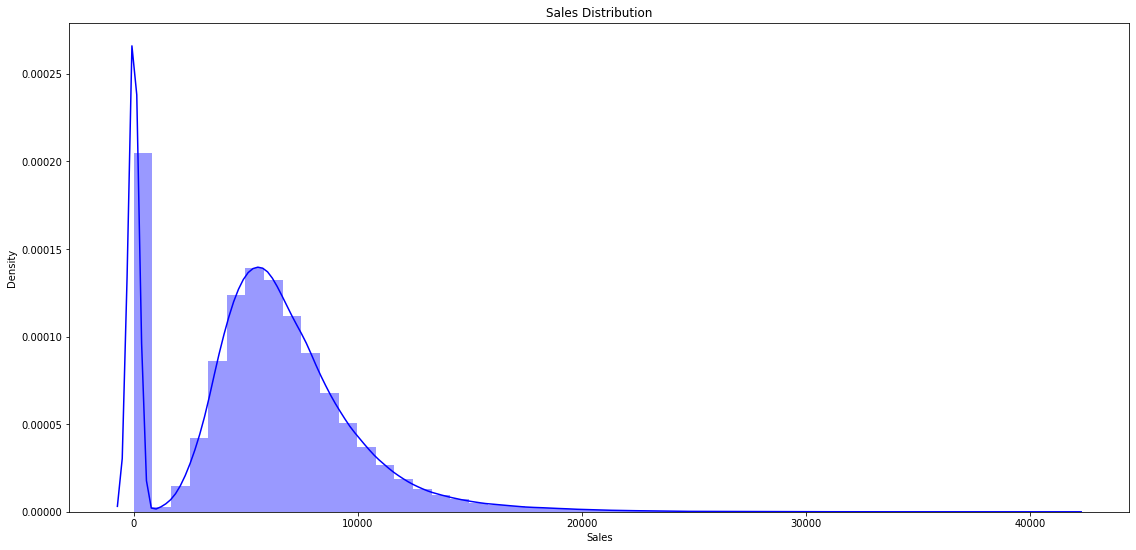

In [ ]:
plt.figure(figsize=(19,9))
sns.distplot(rs_df["Sales"],color="B")
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.show()

1.As we can see it is positively skewed.So there might be some outlayers

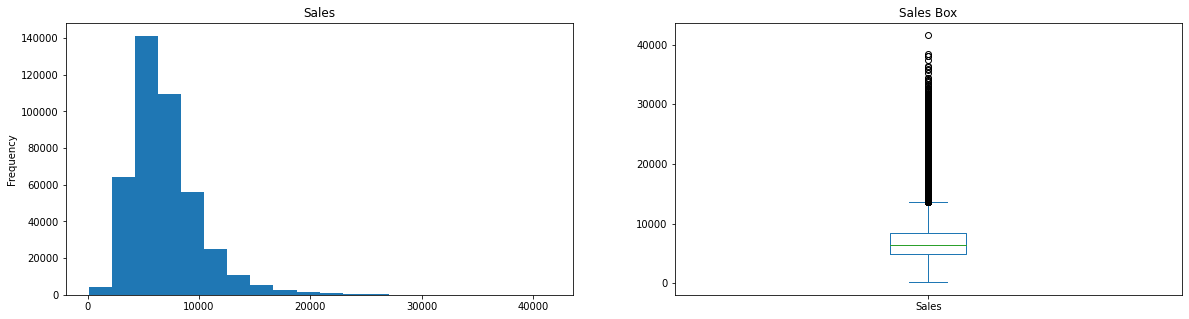

In [ ]:
f, ax = plt.subplots(1,2, figsize = (20, 5))

open_sales.Sales.plot(kind = "hist", title = "Sales", bins = 20, ax = ax[0])
open_sales.Sales.plot.box(title = "Sales Box", ax = ax[1])

In [ ]:
print("Rossmann has", round(open_sales.Sales[(open_sales.Sales > 10000)].count() / open_sales.shape[0] * 100, 2), 
      "% of the time big sales, over 15.000")
print("Rossmann has", round(open_sales.Sales[(open_sales.Sales < 1000)].count() / open_sales.shape[0] * 100, 4), 
      "% of the time low sales, under 1000")

Rossmann has 13.45 % of the time big sales, over 15.000
Rossmann has 0.0277 % of the time low sales, under 1000


In [ ]:
rs_df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

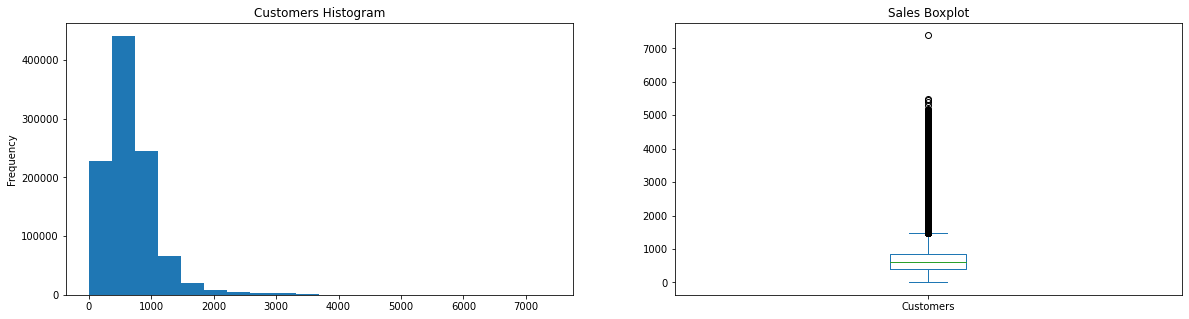

In [ ]:
f, ax = plt.subplots(1,2, figsize = (20, 5))

rs_df.Customers.plot(kind = "hist", title = "Customers Histogram", bins = 20, ax = ax[0])
rs_df.Customers.plot.box(title = "Sales Boxplot", ax = ax[1])

In [ ]:
rs_df[(rs_df.Customers > 7000)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
993496,817,2,2013-01-22,27190,7388,1,1,0,0


**We have a outlayers.When we analyze that on one specific day(2013-01-22) the customers were all time high** 

In [ ]:
print("Different stores where closed for", rs_df[(rs_df.Open == 0)].count()[0], "times in a respective time")
print(rs_df[(rs_df.Open == 0) & ((rs_df.StateHoliday == "a") | (rs_df.StateHoliday == "b") | (rs_df.StateHoliday == "c"))].count()[0], "times the stores were closed because of holidays by state")
print(rs_df[(rs_df.Open == 0) & (rs_df.SchoolHoliday == 1)].count()[0], "times, some stores were closed because of school")
print("The stores were in some sundays opend", rs_df[(rs_df.Open == 1) & (rs_df.DayOfWeek == 7)].count()[0], "times")
print("However,", rs_df[(rs_df.Open == 0) & ((rs_df.StateHoliday == "0") | (rs_df.StateHoliday == 0)) & (rs_df.SchoolHoliday == 0)].count()[0], 
      "times, the stores were closed for no reason (No Holidays o Sunday)")

Different stores where closed for 172817 times in a respective time
30140 times the stores were closed because of holidays by state
18264 times, some stores were closed because of school
The stores were in some sundays opend 3593 times
However, 139610 times, the stores were closed for no reason (No Holidays o Sunday)


**The above gives the details of store opened and closed details**

In [ ]:
print(round((rs_df.Promo[rs_df.Promo == 1].count() / rs_df.shape[0] * 100), 3), "% of the time,promotions made by store ")

38.151 % of the time,promotions made by store 


**Tells us that the promation we made lot by the stores**

In [ ]:
rs_df.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
rs_df["StateHoliday_final"] = rs_df["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})
rs_df.StateHoliday_final.count()

1017209

In [ ]:
rs_df["StateHoliday"].values

array(['0', '0', '0', ..., 'a', 'a', 'a'], dtype=object)

rs_df = rs_df.drop("StateHoliday", axis = 1)
**We have dropped the stateholiday as we have updated it to stateholidat final **

In [ ]:
rs_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_final
0,1,5,2015-07-31,5263,555,1,1,0,1,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0
4,5,5,2015-07-31,4822,559,1,1,0,1,0


In [ ]:
rs_df = rs_df.drop(rs_df[(rs_df.Open == 0) & (rs_df.Sales == 0)].index)
rs_df = rs_df.reset_index(drop = True) 
rs_df.isnull().all()

Store                 False
DayOfWeek             False
Date                  False
Sales                 False
Customers             False
Open                  False
Promo                 False
StateHoliday          False
SchoolHoliday         False
StateHoliday_final    False
dtype: bool

**delete the times, where the stores were opened with no sales because of days in inventory.**

# **Now can analyse the Store dataset**

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


the median is 2325.0 and mean is 5404.901079136691


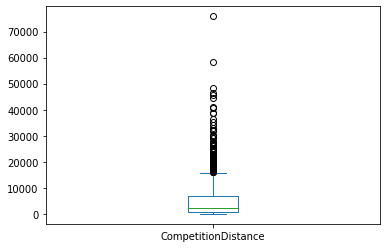

In [ ]:
store_df.CompetitionDistance.plot.box()
print("the median is", store_df.CompetitionDistance.median(), "and mean is", store_df.CompetitionDistance.mean())

**we can see the outliers, so we can choose between mean and median to fill the NaN.As there are outlayers we can choose median to fill the NaN**

In [ ]:
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median(), inplace = True)

In [ ]:
store_df["CompetitionOpenSinceMonth"].fillna(0, inplace = True)
store_df["CompetitionOpenSinceYear"].fillna(0, inplace = True)

**As in both promo and CompetitionOpen we are replacing NaN with 0 because as there is nan value we assume no promotion and competition at that time so assuming zero**

In [ ]:
store_df["Promo2SinceWeek"].fillna(0, inplace = True)
store_df["Promo2SinceYear"].fillna(0, inplace = True)
store_df["PromoInterval"].fillna(0, inplace = True)

**Now we had replaced all the NaN values**

In [ ]:
df = pd.merge(rs_df, store_df, how = "left", on = "Store")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Open                       844392 non-null  int64  
 6   Promo                      844392 non-null  int64  
 7   StateHoliday               844392 non-null  object 
 8   SchoolHoliday              844392 non-null  int64  
 9   StateHoliday_final         844392 non-null  int64  
 10  StoreType                  844392 non-null  object 
 11  Assortment                 844392 non-null  object 
 12  CompetitionDistance        844392 non-null  float64
 13  CompetitionOpenSinceMonth  84

**Now all the missing data of both the set had been filled so we have merged the data set so a single data set for further.**

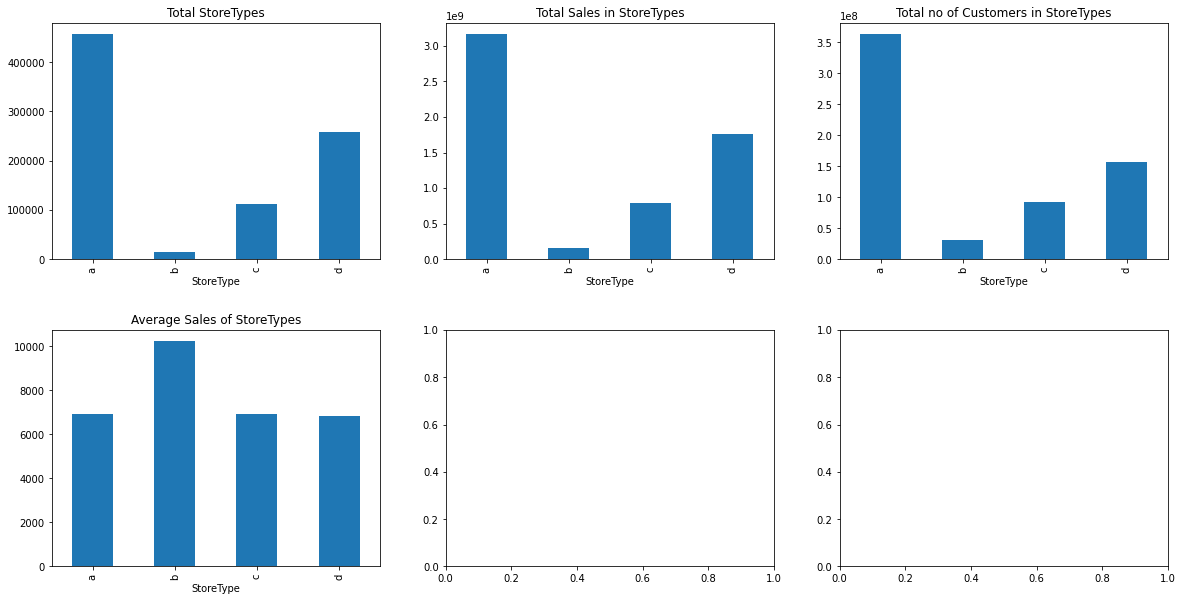

In [ ]:
f, ax = plt.subplots(2, 3, figsize = (20,10))

df.groupby("StoreType")["Store"].count().plot(kind = "bar", ax = ax[0, 0], title = "Total StoreTypes")
df.groupby("StoreType")["Sales"].sum().plot(kind = "bar", ax = ax[0,1], title = "Total Sales in StoreTypes")
df.groupby("StoreType")["Customers"].sum().plot(kind = "bar", ax = ax[0,2], title = "Total no of Customers in StoreTypes")
df.groupby("StoreType")["Sales"].mean().plot(kind = "bar", ax = ax[1,0], title = "Average Sales of StoreTypes")

plt.subplots_adjust(hspace = 0.3)
plt.show()

**we can see from the graphs,**


1.The StoreType A has the most stores, sales and customers.Whereas B has the highest average sales  

2.StoreType B has the stores, sales and customers.


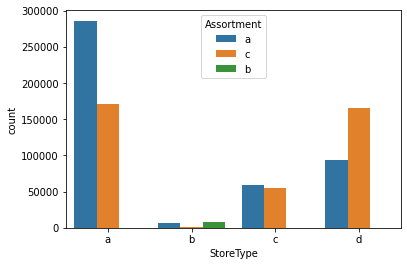

In [ ]:
sns.countplot(data = df, x = "StoreType", hue = "Assortment", order=["a","b","c","d"]) 
plt.show()

**only the StoreType B has 3 assortments other has 2 assartments.But A have high in count**

In [ ]:
df.Date = df.Date.astype("datetime64[ns]")
df["Month"] = df.Date.dt.month
df["Year"] = df.Date.dt.year
df["Day"] = df.Date.dt.day

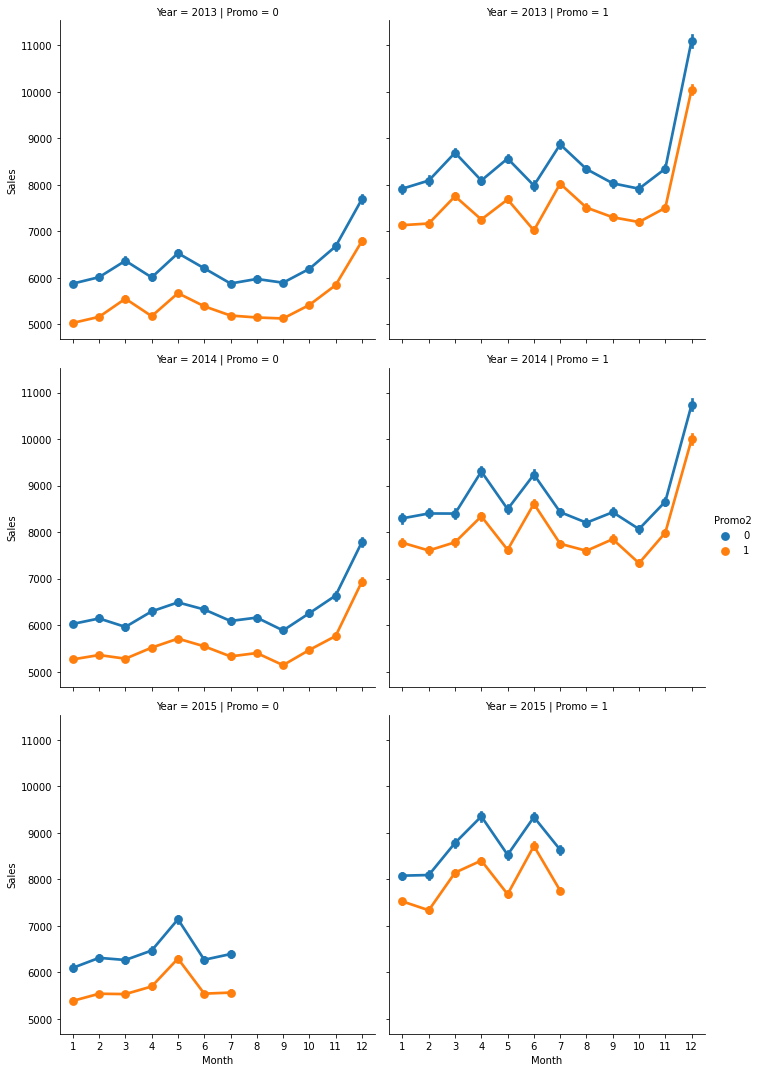

In [ ]:
sns.factorplot(data = df, x ="Month", y = "Sales", 
               col = 'Promo', 
               hue = 'Promo2',
               row = "Year")

1.In 2013 when there is no promotion sales increased but not in a high amount.When there is a promation we can see high difference in the sales.

2.same trens in the year 2014 follows.

3.When we compare the 2015 year with month when there is no promotion sales was less.When compared with the promotion.

4.There is one suprising analyse that,in the non promotion we can see that in the month of may has the high sales,but in case of promotin may has low sales



In [ ]:
df["StoreType"] = df["StoreType"].astype("category")
df["Assortment"] = df["Assortment"].astype("category")
df["PromoInterval"] = df["PromoInterval"].astype("category")
df["StoreType_final"] = df["StoreType"].cat.codes
df["Assortment_final"] = df["Assortment"].cat.codes
df["PromoInterval_final"] = df["Assortment"].cat.codes
df["StateHoliday_final"] = df["StateHoliday_final"].astype("float")

Converting all the datatypes 

In [ ]:
def plot_bar_graph_with_two_features(dataframe, x_feature, y_feature):
  if type(y_feature) == list:
    size = len(y_feature)
    fig, axes = plt.subplots(1, size, figsize=(10*size, 6))
    column = -1
    for feature in y_feature:
      column += 1
      sns.barplot(ax=axes[column], x=dataframe[x_feature], y=dataframe[feature], estimator=sum)
      axes[column].set_title(f"Sum of {feature} vs {x_feature}")
  else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=dataframe[x_feature], y=dataframe[y_feature], estimator=sum)
    ax.set_title(f"Sum of {y_feature} vs {x_feature}")
    plt.show()

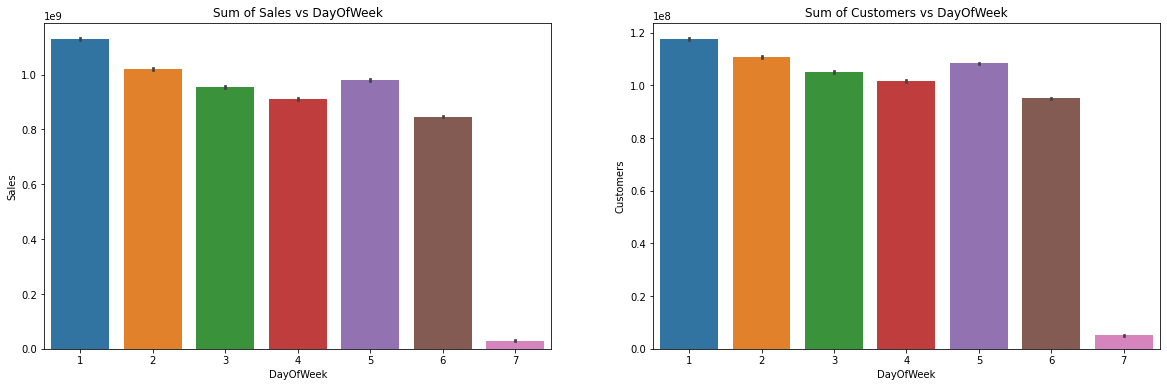

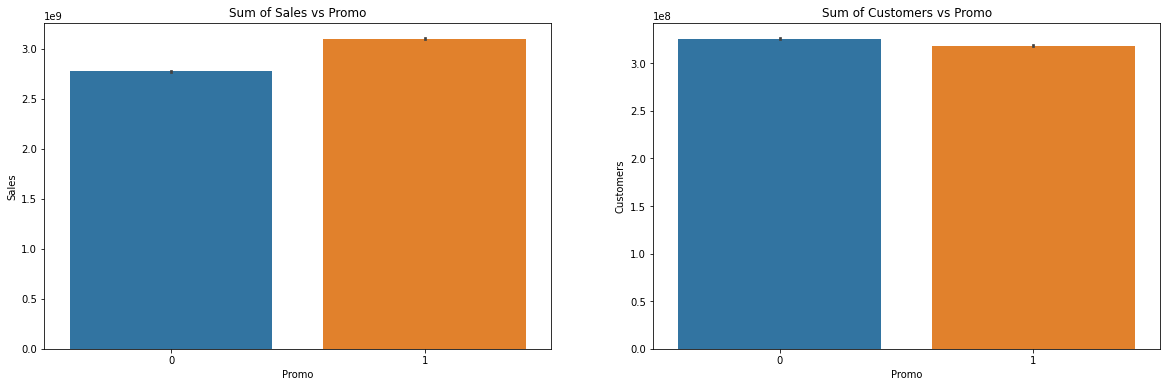

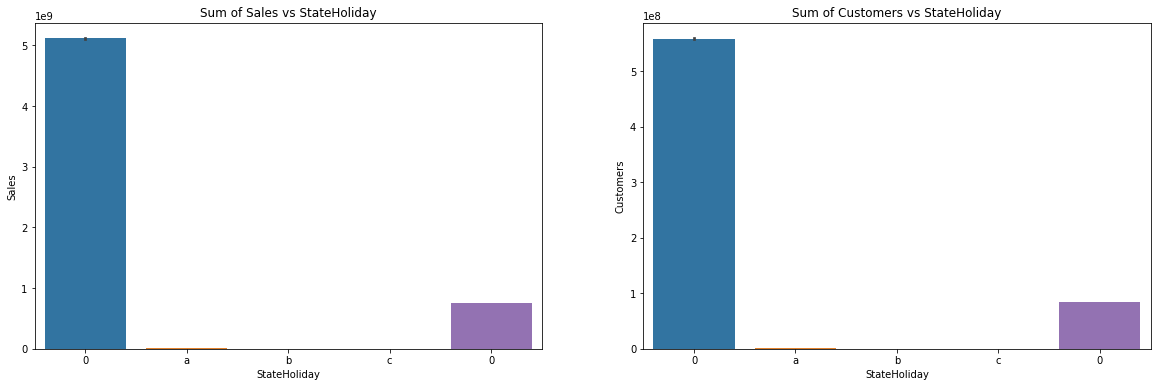

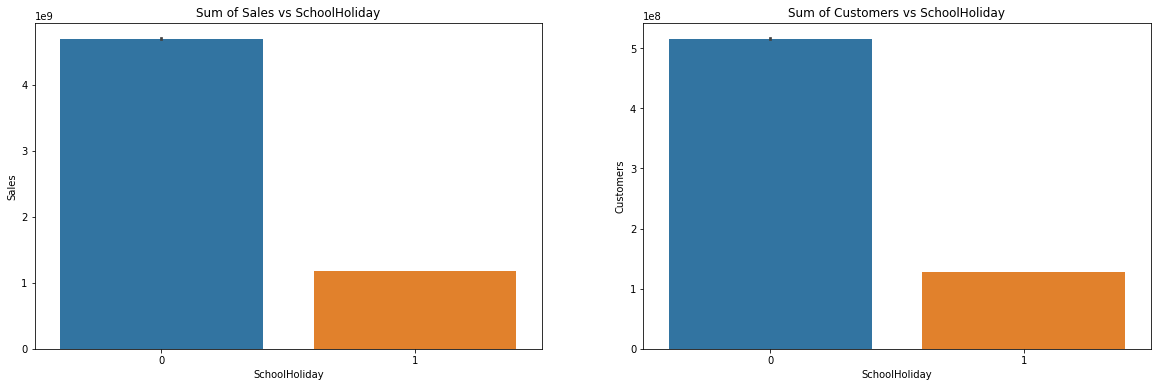

In [ ]:
# categotical variables under consideration
categorical_variables = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday']

# plot bar graphs for each categorical variable against the sum of sales
for feature in categorical_variables:
  plot_bar_graph_with_two_features(rs_df, feature, ['Sales', 'Customers'])

The following observations were made from the above graphs:

> Highest sales are recorded on Mondays and lowest sales are recorded on Sundays.


> This may be because most of the shops are closed on Sundays and this leads to higher demand on the next day, which is Monday.


> Presence of promos increases sales.


> Shops are closed on all state holidays but sometimes some shops are opened during school holidays, which may be Saturdays.


> Sales are higher on school holidays than other days.













**Converting the categorical values**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StateHoliday_final         844392 non-null  float64       
 10  StoreType                  844392 non-null  category      
 11  Assortment                 844392 non-null  category

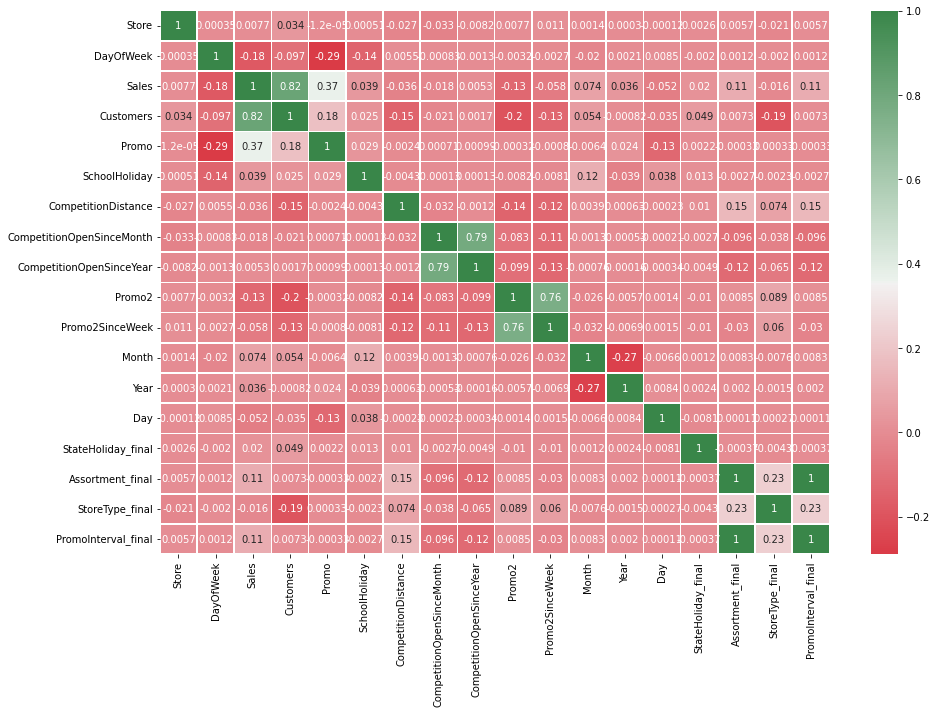

In [ ]:
df_correlation = df[["Store", "DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "CompetitionDistance", 
                                 "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", 
                                 "Month", "Year", "Day", "StateHoliday_final", "Assortment_final", "StoreType_final", "PromoInterval_final"]]
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax = ax, annot=True, cmap=sns.diverging_palette(10, 133, as_cmap=True), linewidths=0.5)

 **we can confirm from the corelation above:Customer vs Sales (0.82) is highly correlated**


**My conclusion of the analysis:**


1.Customers and sales are also highly correlated because an increase in customers means that there must be an increase in sales too.

2.We can see that week of year and month are highly correlated, which is obvious since they represent points in the same timeframe but with different range.


3.Promo2 is correlated with promo2 since week and promo2 since year because promo2 is a binary feature and promo2 since week and promo2 since year have the value of 1 only when promo2 is 1.


4.Competition open number of months is highly correlated with competition open since year because it is derived from the latter.

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_final,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,Day,StoreType_final,Assortment_final,PromoInterval_final
0,1,5,2015-07-31,5263,555,1,1,0,1,0.0,...,0,0.0,0.0,0,7,2015,31,2,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0.0,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015,31,0,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0.0,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015,31,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0.0,...,0,0.0,0.0,0,7,2015,31,2,2,2
4,5,5,2015-07-31,4822,559,1,1,0,1,0.0,...,0,0.0,0.0,0,7,2015,31,0,0,0


It is the dataset after converting all the features

In [ ]:
x=df1 = df.drop(['StoreType','Assortment','PromoInterval','Date','SchoolHoliday','StateHoliday','Sales'], axis=1)
y=rs_df.Sales

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Customers                  844392 non-null  int64  
 3   Open                       844392 non-null  int64  
 4   Promo                      844392 non-null  int64  
 5   StateHoliday_final         844392 non-null  float64
 6   CompetitionDistance        844392 non-null  float64
 7   CompetitionOpenSinceMonth  844392 non-null  float64
 8   CompetitionOpenSinceYear   844392 non-null  float64
 9   Promo2                     844392 non-null  int64  
 10  Promo2SinceWeek            844392 non-null  float64
 11  Promo2SinceYear            844392 non-null  float64
 12  Month                      844392 non-null  int64  
 13  Year                       84

Now the data is ready for further process

# **Train-Test split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)

We are loading 80% data to train and 20% data to split

**Linear Regression model**

In [ ]:
reg = LinearRegression()

In [ ]:
reg.fit(x_train,y_train)

LinearRegression()

# **Evaluation Matrix**

In [ ]:
reg.score(x_train, y_train)

0.7651168761535645

In [ ]:
reg.coef_


array([-1.57706976e-01, -6.93208427e+01,  6.36606740e+00,  1.31420999e-08,
        1.28610019e+03, -2.02281975e+03,  2.86759025e-02, -5.23910430e+00,
        1.13318166e-01,  1.35841859e+05,  1.07578938e+01, -6.75205378e+01,
        4.07860962e+01,  1.76498425e+02,  1.20287830e+00,  2.72223680e+02,
        1.09992356e+02,  1.09992356e+02])

In [ ]:
y_pred = reg.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  
  
# get cross validation scores 
y_predicted = reg.predict(x_train)
y_test_predicted = reg.predict(x_test)

print("Regresion Model Score" , ":" , reg.score(x_train, y_train) , "," ,
      "Out of Sample Test Score" ,":" , reg.score(x_test, y_test))
print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
r2 = r2_score(y_test, y_test_predicted)
print("Testing R2 :" ,r2)


Regresion Model Score : 0.7651168761535645 , Out of Sample Test Score : 0.7649929302490823
Training RMSE : 1503.560338905174 Testing RMSE : 1508.3937864825039
Testing R2 : 0.7649929302490823


***Above result gives information about the Training and Testing evaluation of Linear model.Here both testing and training are nearly correlated,so the fit is optimal***

**Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge

ridge  = Ridge(alpha=0.1)

In [ ]:
ridge.fit(x_train,y_train)

Ridge(alpha=0.1)

In [ ]:
ridge.score(x_train, y_train)

0.7650551710490336

In [ ]:
y_pred_r = ridge.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error

MSE  = mean_squared_error(y_test,y_pred_r)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test,y_pred_r)
print("R2 :" ,r2)

MAE = mean_squared_error(y_test,y_pred_r)
print("MAE :" , MAE)

MSE : 2275951.433602352
RMSE : 1508.6256770989787
R2 : 0.7649206677885848
MAE : 2275951.433602352


# **As our model performs good in ridge as got R2=76%**

**Ridge Regression with Hyperparameter Tuning**

In [ ]:
# train data with ridge regression
ridge = Ridge()
parameters = {'alpha':[1e-15,1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only one hyperparameter
# cv=3 since dataset is large
reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
reg.fit(x_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for ridge regression: ")
for key, value in reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {reg.best_score_}")

The best parameters for ridge regression: 
alpha=1e-08

Negative mean squared error: -2260897.5616372563


In [ ]:
# predict the train and test data
riy_train_pred = reg.predict(x_train)
riy_test_pred = reg.predict(x_test)

The result of hyper parmeter tuning and best paremeters are shown with NMSE

In [ ]:
regression_Dataframe = pd.DataFrame(zip((y_test/1000), (y_test_pred/1000)), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,11.256,11.643006
1,5.124,5.783620
2,5.805,7.823141
3,4.859,5.820118
4,5.854,7.088100
...,...,...
168874,5.587,7.338566
168875,6.046,5.734954
168876,8.611,7.886839
168877,9.153,9.051930


The above shows the actual and predicted values

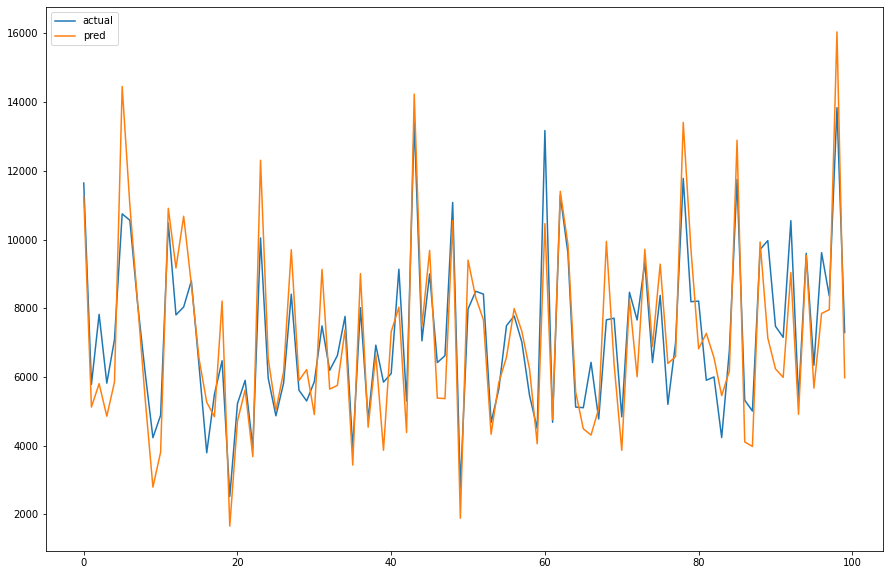

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y_test_pred[:100])
plt.plot(np.array(y_test[:100]))
plt.legend(['actual', 'pred'])
plt.show()

**The above plot give the graphical understanging of our actual and predicted data for 100 values as dataset is high i das taken only 100 data for ploting**

In [ ]:
def calculate_rmspe(y_actual, y_pred):
  return (np.sqrt(np.mean(np.square(y_actual.to_numpy() - y_pred))) / np.mean(y_actual.to_numpy())) * 100

In [ ]:
def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
  metrics_dict = {}

  metrics_dict['Train_R2'] = r2_score(y_train, y_train_pred)
  metrics_dict['Test_R2'] = r2_score(y_test, y_test_pred)
  metrics_dict['Train_RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
  metrics_dict['Test_RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
  metrics_dict['Train_RMSPE'] = calculate_rmspe(y_train, y_train_pred)
  metrics_dict['Test_RMSPE'] = calculate_rmspe(y_test, y_test_pred)

  return metrics_dict

In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, riy_train_pred, y_test, riy_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

Training Data
R2    : 0.7651168761535647
RMSE  : 1503.5603389051735
RMSPE : 21.61408945107459%

Testing Data
R2    : 0.7649929302479258
RMSE  : 1508.3937864862153
RMSPE : 21.697227051725704%


# **Evaluation Result of our model by Ridge**

In [ ]:
#  add metrics to metrics table
metrics_table = pd.DataFrame(columns=['Regression_Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_RMSPE', 'Test_RMSPE'])

In [ ]:
metrics_table.loc[len(metrics_table.index)] = ('Ridge', model_evaluation['Train_R2'], model_evaluation['Test_R2'], model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE'])

The above code gives the details of metrics table

**Ridge Regression plot**

Text(0, 0.5, 'Predicted sales')

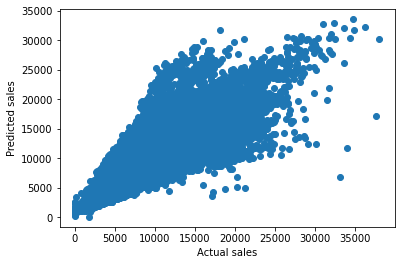

In [ ]:
plt.scatter((y_test),(y_pred_r))
plt.xlabel('Actual sales')
plt.ylabel('Predicted sales')

**Scatter plot of actual and predicted sales**

**Residual Analysis**

Text(0.5, 0.98, 'Residual Analysis')

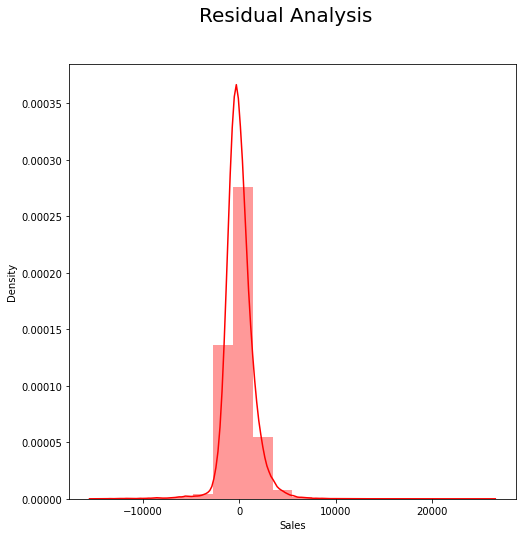

In [ ]:
#Resuldual Analysis
fig=plt.figure(figsize=(8,8))
  
sns.distplot((y_test)-(y_pred_r),bins=20,color='r')

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)  

**Residual analysis were it is been normally ditributed**

# **Lasso Regression with Hyperparameter Tuning**

In [ ]:
lasso  = Lasso(alpha=0.1 , max_iter= 3000)

In [ ]:
lasso.fit(x_train, y_train)

Lasso(alpha=0.1, max_iter=3000)

In [ ]:
lasso.score(x_train, y_train)

0.7645112937370137

In [ ]:
y_pred_l = lasso.predict(x_test)

In [ ]:
MSE  = mean_squared_error((y_test),(y_pred_l))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test),(y_pred_l))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test),(y_pred_l)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

MSE : 2281391.3284207173
RMSE : 1510.42753166801
R2 : 0.7643587898757607
Adjusted R2 :  0.7643336711870112


# **As our model performs good in lasso as got R2=76%**

**Lasso Regression with Hyperparameter Tuning**

In [ ]:
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=3)
lasso_regressor.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
y_pred_lasso = lasso_regressor.predict(x_test)

In [ ]:
MSE  = mean_squared_error((y_test),(y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test),(y_pred_lasso))
print("R2 :" ,r2)

MSE : 2281372.1917237723
RMSE : 1510.4211967937197
R2 : 0.7643607664741503


In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_predicted, y_test, y_pred_lasso)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


Training Data
R2    : 0.7651168761535645
RMSE  : 1503.560338905174
RMSPE : 21.6140894510746%

Testing Data
R2    : 0.7643607664741503
RMSE  : 1510.4211967937197
RMSPE : 21.726389981302205%


# **Evaluation Result of our model by Lasso**

In [ ]:
metrics_table.loc[len(metrics_table.index)] = ('Lasso', model_evaluation['Train_R2'], model_evaluation['Test_R2'], model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE'])

In [ ]:
regression_Lasso = pd.DataFrame(zip((y_test/1000), (y_pred_lasso/1000)), columns = ['actual', 'pred'])
regression_Lasso

,actual,pred
0,11.256,11.646784
1,5.124,5.781038
2,5.805,7.824222
3,4.859,5.815442
4,5.854,7.092418
...,...,...
168874,5.587,7.384726
168875,6.046,5.730434
168876,8.611,7.879537
168877,9.153,9.169652


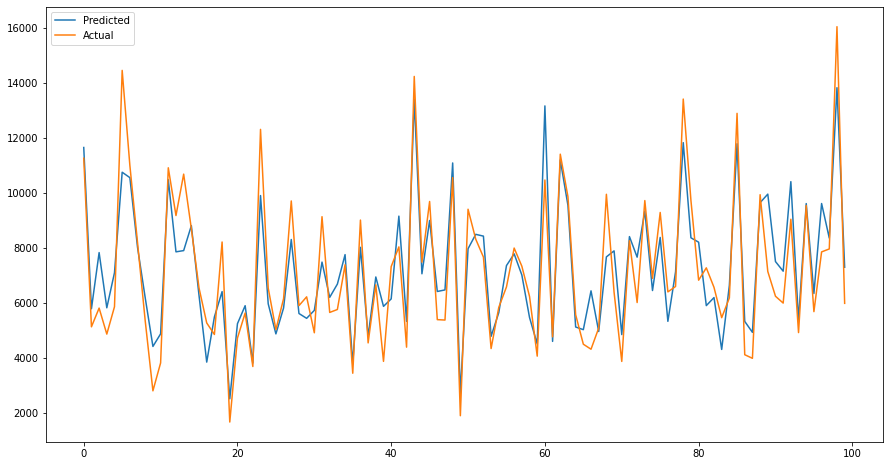

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(y_pred_lasso[:100])
plt.plot(np.array(y_test[:100]))
plt.legend(["Predicted","Actual"])
plt.show()

The above plot give the graphical understanging of our actual and predicted data for 100 values as dataset is high i das taken only 100 data for ploting

# **Elastic Net Regression with Hyperparameter Tuning**

In [ ]:
# train data with elastic net regression
elastic_net = ElasticNet()
parameters = {'alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5],'l1_ratio':[0.3,0.4,0.5,0.6,0.7]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only two hyperparameters
# cv=3 since dataset is large
elastic = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=3)
elastic.fit(x_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for elastic net regression: ")
for key, value in elastic.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {elastic.best_score_}")

The best parameters for elastic net regression: 
alpha=1e-08
l1_ratio=0.7

Negative mean squared error: -2266680.1296801376


In [ ]:
# predict the train and test data
eny_train_pred = elastic.predict(x_train)
eny_test_pred = elastic.predict(x_test)

In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, eny_train_pred, y_test, eny_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

Training Data
R2    : 0.7645160902220246
RMSE  : 1505.482020193232
RMSPE : 21.64171414306853%

Testing Data
R2    : 0.7643607666232685
RMSE  : 1510.4211963158043
RMSPE : 21.726389974427715%


In [ ]:
metrics_table.loc[len(metrics_table.index)] = ('ElasticNet', model_evaluation['Train_R2'], model_evaluation['Test_R2'], model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE'])

Conclusion from EDA

1.   From EDA, Mondays has most sales since most of the Sundays are closed therefore sales is less in sunday.
2.    Promotions seem to have a significant effect on sales but not for the number of customers.
3. It is advisable to spend more on promos to get higher returns.
4. Weekly sales and customers peak at the mid-December. It may be guessed that people buy in advance just before the shops close for the holiday season.


Conclusions from Modelling


1.The regression model that is declared to be a significant model by using model utility test could not guarantee a strong linear relationship between the independent and dependent variable. 

2.In view of the weakness in model utility test, other measures should
be explored as alternatives to model utility test.An alternative measure is recommended as follow:

3.If the R2 of a regression model is in the range of 0-0.25, the regression
model is not significant. The regression model should not be used for
further inferences. 

54.If the R2 of a regression model is in the range of 0.64-1, the regression
model is strongly significant.If the R2 of a regression model is in between 0.25 and 0.64, theinferences such as predictions made from the regression model should be interpreted with caution.

**5.As our mosel has R2 as 0.76 our model is strongly significant.**

6.we evaluated sales with several features in different significance levels within the consideration of multicollinearity. As a result, we have achieved to build a regression model in **Regresion Model Score : 0.7651168761535645 , Out of Sample Test Score : 0.7649929302490823 Training RMSE : 1503.560338905174 Testing RMSE : 1508.3937864825039 Testing R2 : 0.7649929302490823.**

**Decision Tree Regression with Hyperparameter Tuning**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# train data with decision tree regression
decision_tree = DecisionTreeRegressor()
parameters = {'max_depth': [5, 10, None],'min_samples_leaf': [1, 3, 7],'min_samples_split': [3, 5, 9],'max_leaf_nodes': [5, 20, 100],'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because DecisionTreeRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
dt_reg = RandomizedSearchCV(estimator=decision_tree, param_distributions=parameters, n_iter=8, cv=3)
dt_reg.fit(x_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for decision tree regression: ")
for key, value in dt_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {dt_reg.best_score_}")


The best parameters for decision tree regression: 
min_samples_split=9
min_samples_leaf=1
max_leaf_nodes=20
max_features=auto
max_depth=None

Negative mean squared error: 0.7661516846540434


In [ ]:
# predict the train and test data
dy_predicted = dt_reg.predict(x_train)
dy_test_pred = dt_reg.predict(x_test)

RandomizedSearchCV is used for hyperparameter tuning because DecisionTreeRegressor() have multiple hyperparameters,cv=3 & iter= 8, since dataset is large

In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, dy_predicted, y_test, dy_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['DecisionTreeRegressor', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                                model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                                model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.7662771439484595
RMSE  : 1499.8421229178173
RMSPE : 21.56063908339088%

Testing Data
R2    : 0.7652019418889963
RMSE  : 1507.7228662630666
RMSPE : 21.687576316920463%


In [ ]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,11256,11134.405283
1,5124,3366.598661
2,5805,7553.657055
3,4859,5683.470238
4,5854,5683.470238
...,...,...
168874,5587,7591.340192
168875,6046,6352.241322
168876,8611,7553.657055
168877,9153,9604.243257


**Random Forest Regression with Hyperparameter Tuning**

In [ ]:
# train data with random forest regression
random_forest = RandomForestRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because RandomForestRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
rf_reg = RandomizedSearchCV(estimator=random_forest, param_distributions=parameters, n_iter=10, cv=3)
rf_reg.fit(x_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters of random forest regression: ")
for key, value in rf_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {rf_reg.best_score_}")

The best parameters of random forest regression: 
min_samples_split=5
min_samples_leaf=2
max_leaf_nodes=100
max_features=sqrt
max_depth=None

Negative mean squared error: 0.7959020432885452


In [ ]:
# predict the train and test data
ry_train_pred = rf_reg.predict(x_train)
ry_test_pred = rf_reg.predict(x_test)

In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, ry_train_pred, y_test, ry_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                          model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                          model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.7932577315809556
RMSE  : 1410.618556990544
RMSPE : 20.278026018124624%

Testing Data
R2    : 0.7918040494398123
RMSE  : 1419.7452035083277
RMSPE : 20.42207698818323%


**XGBoost Regression with Hyperparameter Tuning**

In [ ]:
# train data with XGBoost regression
xgboost = xgb.XGBRegressor(objective='reg:linear', verbosity=0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

# RandomizedSearchCV is used for hyperparameter tuning because XGBRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
xg_reg = RandomizedSearchCV(estimator=xgboost, param_distributions=parameters, n_iter=10, cv=3)
xg_reg.fit(x_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for XGBoost regression: ")
for key, value in xg_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {xg_reg.best_score_}")

The best parameters for XGBoost regression: 
min_child_weight=2
max_depth=10
learning_rate=0.2
gamma=0
colsample_bytree=0.7

Negative mean squared error: 0.9800622424058032


In [ ]:
# predict the train and test data
xgy_train_pred = xg_reg.predict(x_train)
xgy_test_pred = xg_reg.predict(x_test)

In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, xgy_train_pred, y_test, xgy_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                          model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                          model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.9852261934698878
RMSE  : 377.08665050801653
RMSPE : 5.42072332183298%

Testing Data
R2    : 0.980537272511923
RMSE  : 434.0863424462932
RMSPE : 6.244039200168405%


In [ ]:
metrics_table[22:]

,Regression_Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_RMSPE,Test_RMSPE
22,Random Forest,0.793258,0.791804,1410.618557,1419.745204,20.278026,20.422077
23,XGBoost,0.985226,0.980537,377.086651,434.086342,5.420723,6.244039
24,Ridge,0.765117,0.764993,1503.560339,1508.393786,21.614089,21.697227
25,Lasso,0.765117,0.764993,1503.560339,1508.393786,21.614089,21.697227
26,ElasticNet,0.764516,0.764361,1505.482020,1510.421196,21.641714,21.726390
27,DecisionTreeRegressor,0.766277,0.765202,1499.842123,1507.722866,21.560639,21.687576


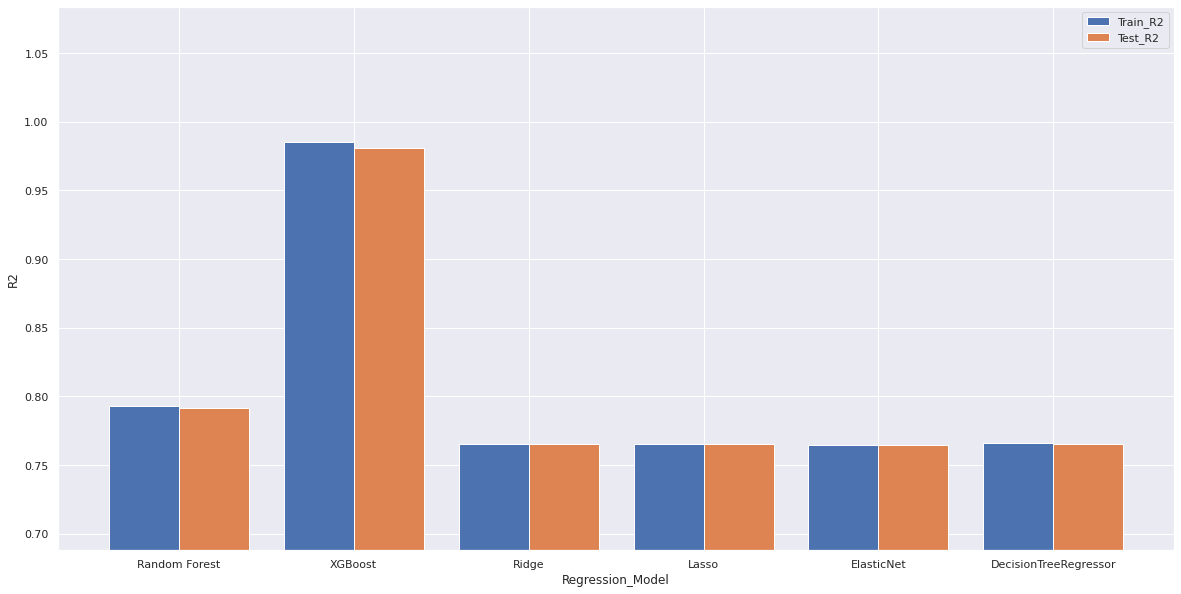

In [ ]:
plot_bar_graph_with_three_features(metrics_table[22:], 'Regression_Model', 'Train_R2', 'Test_R2', 'R2')

Conclusions from Modelling


1.The model built using XGBoost algorithm gives high accuracy. 

2.Among the remaining, the model built using random forest algorithm is the most accurate one. 

3.This can be attributed to higher number of categorical features in the data.

4.If model interpretability is more important than accuracy, model built using decision tree algorithm should be chosen over the one using random forest algorithm. Since the difference between accuracy of these two models is less than 3%, there won't be a large difference in the result.

5.Decision tree based algorithms are slightly more accurate than linear regression based algorithms.